In [1]:
import tarfile
import tempfile
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from ugradiolab.data import Record
from ugradiolab.analysis import Spectrum

/home/ikaros/projects/ay-121/.venv/lib/python3.12/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
CAL_ARCHIVE = Path('../../data/lab_2_1_cal_20260221_172937.tar.gz')

def load_records_from_archive(archive_path: Path) -> list[Record]:
    """Load all .npz files from a tar.gz as Records, sorted by filename."""
    with tempfile.TemporaryDirectory() as tmpdir:
        with tarfile.open(archive_path) as tar:
            tar.extractall(tmpdir, filter='data')
        return [Record.load(p) for p in sorted(Path(tmpdir).rglob('*.npz'))]

records = load_records_from_archive(CAL_ARCHIVE)
spectra = [Spectrum.from_record(r) for r in records]

for r, spec in zip(records, spectra):
    print(f'  siggen={r.siggen_freq/1e6:.3f} MHz  amp={r.siggen_amp:.0f} dBm  '
          f'nblocks={r.nblocks}  total_power={spec.total_power:.4f}')

  siggen=1421.000 MHz  amp=-40 dBm  nblocks=512  total_power=1.3603
  siggen=1421.000 MHz  amp=-60 dBm  nblocks=512  total_power=1.3603
  siggen=1421.000 MHz  amp=-80 dBm  nblocks=512  total_power=1.3603


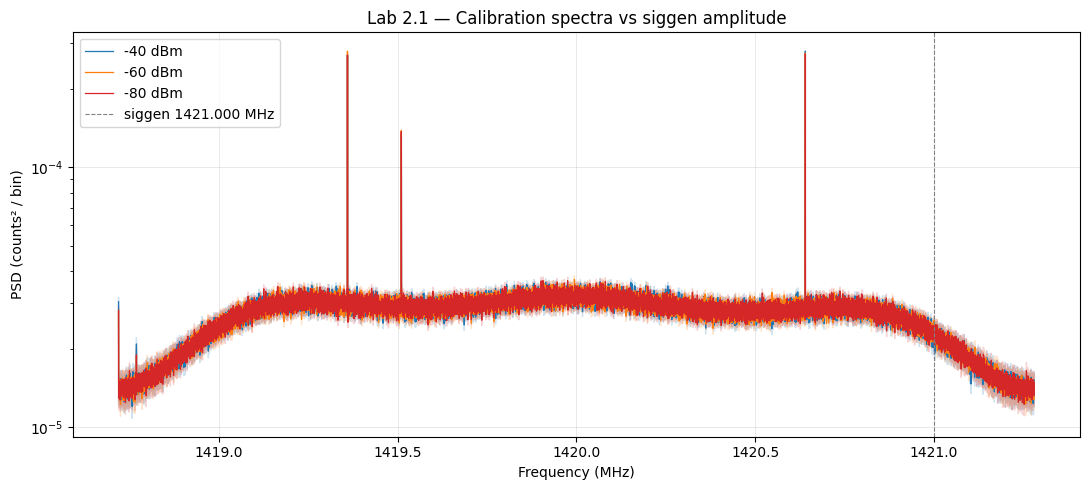

In [3]:
colors = ['tab:blue', 'tab:orange', 'tab:red']

fig, ax = plt.subplots(figsize=(11, 5))

for rec, spec, color in zip(records, spectra, colors):
    lo_bin = spec.bin_at(rec.center_freq)
    psd = spec.psd.copy()
    psd[lo_bin] = np.nan

    ax.fill_between(spec.freqs_mhz, psd - spec.std, psd + spec.std,
                    color=color, alpha=0.2)
    ax.semilogy(spec.freqs_mhz, psd, color=color, lw=0.9,
                label=f'{rec.siggen_amp:.0f} dBm')

ax.axvline(records[0].siggen_freq / 1e6, color='gray', lw=0.8,
           linestyle='--', label=f'siggen {records[0].siggen_freq/1e6:.3f} MHz')

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts² / bin)')
ax.set_title('Lab 2.1 — Calibration spectra vs siggen amplitude')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()

In [4]:
OBS_ARCHIVE = Path('../../data/lab_2_1_1420_20260221_170911.tar.gz')

obs_records = load_records_from_archive(OBS_ARCHIVE)
obs_records.sort(key=lambda r: r.nblocks)
obs_spectra = [(r.nblocks, Spectrum.from_record(r)) for r in obs_records]

for n, spec in obs_spectra:
    print(f'  nblocks={n:>5d}  total_power={spec.total_power:.4f}')

  nblocks=    2  total_power=1.3660
  nblocks=    8  total_power=1.3631
  nblocks=   32  total_power=1.3607
  nblocks=  128  total_power=1.3611
  nblocks=  512  total_power=1.3611
  nblocks= 2048  total_power=1.3610


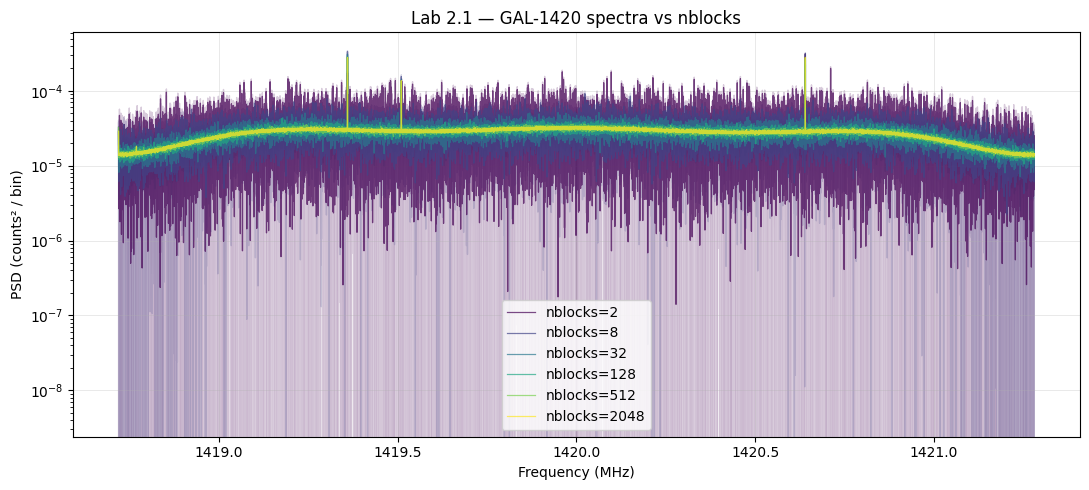

In [5]:
cmap = plt.colormaps['viridis']
colors = [cmap(i / max(len(obs_spectra) - 1, 1)) for i in range(len(obs_spectra))]

fig, ax = plt.subplots(figsize=(11, 5))

for rec, (n, spec), color in zip(obs_records, obs_spectra, colors):
    lo_bin = spec.bin_at(rec.center_freq)
    psd = spec.psd.copy()
    psd[lo_bin] = np.nan

    ax.fill_between(spec.freqs_mhz, psd - spec.std, psd + spec.std,
                    color=color, alpha=0.2)
    ax.semilogy(spec.freqs_mhz, psd, color=color, lw=0.9, alpha=0.7, label=f'nblocks={n}')

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts² / bin)')
ax.set_title('Lab 2.1 — GAL-1420 spectra vs nblocks')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()

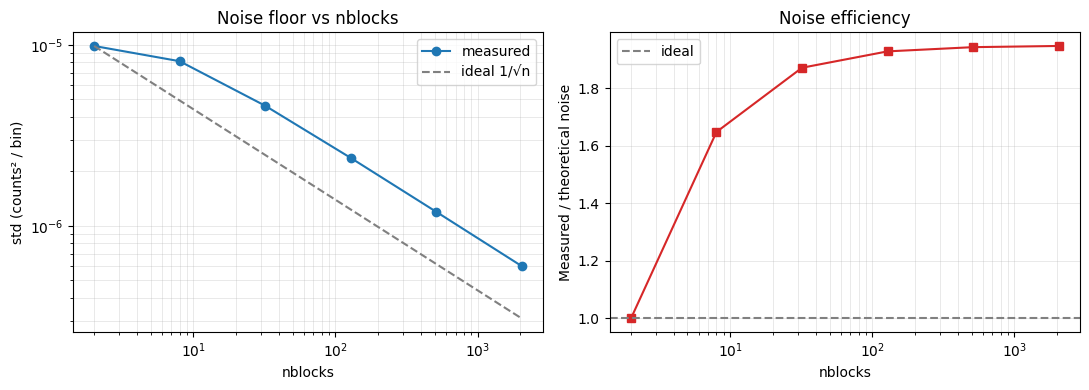

  nblocks=    2  noise=0.00001  efficiency=1.000
  nblocks=    8  noise=0.00001  efficiency=1.647
  nblocks=   32  noise=0.00000  efficiency=1.870
  nblocks=  128  noise=0.00000  efficiency=1.927
  nblocks=  512  noise=0.00000  efficiency=1.942
  nblocks= 2048  noise=0.00000  efficiency=1.946


In [6]:
ns    = np.array([n for n, _ in obs_spectra])
noise = np.array([spec.std for _, spec in obs_spectra])

theoretical = noise[0] / np.sqrt(ns / ns[0])
efficiency  = noise / theoretical

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

ax1.loglog(ns, noise,       'o-', label='measured')
ax1.loglog(ns, theoretical, '--', color='gray', label='ideal 1/√n')
ax1.set_xlabel('nblocks')
ax1.set_ylabel('std (counts² / bin)')
ax1.set_title('Noise floor vs nblocks')
ax1.legend()
ax1.grid(True, which='both', lw=0.4, alpha=0.5)

ax2.semilogx(ns, efficiency, 's-', color='tab:red')
ax2.axhline(1.0, color='gray', linestyle='--', label='ideal')
ax2.set_xlabel('nblocks')
ax2.set_ylabel('Measured / theoretical noise')
ax2.set_title('Noise efficiency')
ax2.legend()
ax2.grid(True, which='both', lw=0.4, alpha=0.5)

fig.tight_layout()
plt.show()

for n, s, e in zip(ns, noise, efficiency):
    print(f'  nblocks={n:>5d}  noise={s:.5f}  efficiency={e:.3f}')